## Special Moves of SFII
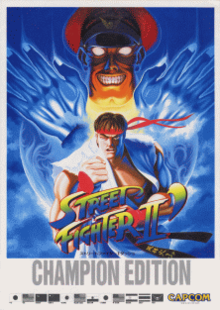

---
### YOLO
YOLOv3-320

In [1]:
import os
from datetime import datetime

os.add_dll_directory('c:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v10.1/bin')
os.add_dll_directory(os.getcwd())

<AddedDllDirectory('D:\\Special-moves-in-Street-Fighter-II')>

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

---
### Build training set

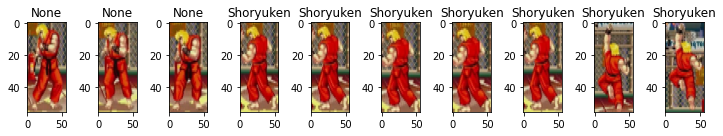

In [3]:
# Load data (deserialize)
with open('movesSF2.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)


# Spliting into training, dev and test set using indexing
dataset_x = unserialized_data['dataset_x']
dataset_y = unserialized_data['dataset_y']
name_classes = {y: x for x, y in unserialized_data['name_classes'].items()}
num_classes = np.unique(dataset_y).shape[0]
indexes = np.arange(dataset_x.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset_x.shape[0])]
test_index  = indexes[int(0.9 * dataset_x.shape[0]) :]
train_x = dataset_x[train_index]
train_y = dataset_y[train_index]
test_x  = dataset_x[test_index]
test_y  = dataset_y[test_index]


# Displaying random choice of dataset
plt.figure(figsize = (10,2))
choice = np.random.choice(dataset_x.shape[0])
for i in range(dataset_x.shape[1]):
    img = dataset_x[choice][i]
    plt.subplot(1,dataset_x.shape[1],i+1)
    plt.gca().set_title(name_classes[int(dataset_y[choice][i])][0:10])
    plt.imshow(img,  aspect='auto')
plt.tight_layout()
plt.show()

In [4]:
print("train_x", train_x.shape, len(train_x))
print("train_y", train_y.shape, len(train_y))
print("test_x", test_x.shape, len(test_x))
print("test_y", test_y.shape, len(test_y))
print("num_classes", num_classes)

train_x (2228, 10, 56, 56, 3) 2228
train_y (2228, 10, 1) 2228
test_x (248, 10, 56, 56, 3) 248
test_y (248, 10, 1) 248
num_classes 4


---
### Import tensorflow framework

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, ConvLSTM2D, MaxPooling3D, BatchNormalization, Dropout

In [6]:
print(tf.__file__)
print("Tensorflow:", tf.__version__)

c:\users\lycob\appdata\local\programs\python\python38\lib\site-packages\tensorflow\__init__.py
Tensorflow: 2.2.0


---
### Categorical train and data set

In [7]:
# convert class vectors to binary class matrices
train_y = keras.utils.to_categorical(train_y, num_classes)
test_y  = keras.utils.to_categorical(test_y,  num_classes)
print(train_y.shape)
print(test_y.shape)

(2228, 10, 4)
(248, 10, 4)


---
### Build Model 

In [8]:

def make_layer_block(model, filter, input=None):
    if input is not None:
        model.add(ConvLSTM2D(
            filters=filter, 
            kernel_size=(3,3), 
            input_shape=input,
            padding="valid", 
            return_sequences=True, 
            activation="relu"))
    else:
        model.add(ConvLSTM2D(
            filters=filter, 
            kernel_size=(3,3), 
            padding="valid", 
            return_sequences=True, 
            activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))


model = Sequential()
make_layer_block(model,  64, (train_x.shape[1:5])) 
make_layer_block(model, 128)
make_layer_block(model,  64)

# extract features and dropout 
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(Dense(num_classes*4, activation='relu'))
model.add(Dense(num_classes*4, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 10, 54, 54, 64)    154624    
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 54, 54, 64)    256       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 27, 27, 64)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 25, 25, 128)   885248    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 25, 25, 128)   512       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 12, 12, 128)   0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 10, 10, 64)    4

In [9]:
print(model.output_shape)
print(train_x.shape)
print(train_y.shape)

(None, 10, 4)
(2228, 10, 56, 56, 3)
(2228, 10, 4)


---
### Training Model

In [10]:
model.compile(
    loss=keras.losses.categorical_crossentropy, 
    optimizer=keras.optimizers.Adam(),
    metrics=['acc'],    
)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 5
batch_size = 8

# Fit the model to the training data.
history = model.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test_x, test_y),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/5
279/279 [==============================] - 423s 2s/step - loss: 0.3725 - acc: 0.8680 - val_loss: 1.4821 - val_acc: 0.0798 - lr: 0.0010
Epoch 2/5
279/279 [==============================] - 434s 2s/step - loss: 0.0316 - acc: 0.9902 - val_loss: 0.3997 - val_acc: 0.8452 - lr: 0.0010
Epoch 3/5
279/279 [==============================] - 430s 2s/step - loss: 0.0130 - acc: 0.9957 - val_loss: 0.0328 - val_acc: 0.9907 - lr: 0.0010
Epoch 4/5
279/279 [==============================] - 429s 2s/step - loss: 0.0075 - acc: 0.9974 - val_loss: 0.0124 - val_acc: 0.9956 - lr: 0.0010
Epoch 5/5
279/279 [==============================] - 428s 2s/step - loss: 0.0066 - acc: 0.9979 - val_loss: 0.0111 - val_acc: 0.9972 - lr: 0.0010


---
### Show loss curves 

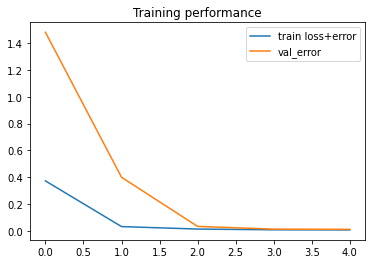

In [11]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

---
### Evaluate

In [12]:
score = model.evaluate(test_x, test_y,batch_size=batch_size, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

31/31 [==============================] - 13s 410ms/step - loss: 0.0111 - acc: 0.9972
Test loss: 0.0110527528449893
Test accuracy: 0.9971774220466614


---
### Save model

In [13]:
model.save('movesSF2_' + str(int(datetime.now().timestamp())) + '.h5')